In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

from sbi.inference import MNLE
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Gamma
from sbi.utils import MultipleIndependent

from sbi.inference import MCMCPosterior, VIPosterior, RejectionPosterior
from sbi.utils.torchutils import atleast_2d

from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

In [18]:
def energy(y1,y2,W_pos=52500,W_neg=8400,B1=0,B2=0,theta=51450):
    # no multiple lines!!!
    E = -W_pos*y1**2 - W_pos*y2**2 + W_neg*y1*y2 - (B1-theta)*y1 - (B2-theta)*y2
    return E


def dEdy1(y1, y2, W_pos, W_neg, B1, theta):
    result = -W_pos*2*y1+W_neg*y2-(B1-theta)
    return result


def dEdy2(y1,y2, W_pos, W_neg, B2, theta):
    result = -W_pos*2*y2+W_neg*y1-(B2-theta)
    return result


def free_energy(y1,y2,N=2000,W_pos=52500,W_neg=8400,B1=0,B2=0,beta=1/24,theta=51450):
    sum_y = -N/2*(y1*np.log(y1)+(1-y1)*np.log(1-y1) + y2*np.log(y2)+(1-y2)*np.log(1-y2)) 
    # no multiple lines!!!
    F = -W_pos*y1**2 - W_pos*y2**2 + W_neg*y1*y2 - (B1-theta)*y1 - (B2-theta)*y2 - beta**(-1)*sum_y
    return F


def dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N):
    #print(log(y1/(1-y1)))
    result = -W_pos*2*y1+W_neg*y2-(B1-theta)+beta**(-1)*0.5*N*(np.log(y1/(1-y1)))
    return result


def dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N):
    result = -W_pos*2*y2+W_neg*y1-(B2-theta)+beta**(-1)*0.5*N*(np.log(y2/(1-y2)))
    return result

def clamp(n, minn=0.0001, maxn=0.9999):
    return(max(min(maxn, n), minn))



def get_state(y1,y2,h):
    overlap = ((y1>(1-h))&(y2>(1-h)))&((y1<h)&(y2<h))
    if overlap:
        return 0
    if(y1>(1-h))&(y2<h):
        state = 1
    elif(y1<h)&(y2>(1-h)):
        state = 2
    else:
        state = 0
    
    return state

In [19]:
## get the probability for all states 
def all_states_prob(N = 1000, beta = 1/24): # here N is the number of neurons in one population
    prob = np.zeros((N, N))
    # first calculate Z
    for i in range(N-1):
        for j in range(N-1):
            y1, y2 = (i+1)/N, (j+1)/N
            prob[i,j] = np.exp(-beta*free_energy(y1, y2))

    Z = np.sum(prob)
    prob_scaled = prob/Z # divided by Z to make it a valid pmf
    
    return prob_scaled



In [20]:
#def continue_sim(y1, y2, h):
#    overlap = ((y1>(1-h))&(y2>(1-h)))&((y1<h)&(y2<h)) # in overlapped region?
#    if overlap:
#        return True
#    else:
#        return ((y1<(1-h))&(y2<(1-h)))|((y1>h)&(y2>h))

In [22]:
def simul_IDM_one_trial(parameters, N = 2000, W_pos = 52500, W_neg = 8400, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450, D = 0.05, sigma = 0.01, 
                        dt = 0.001, init_loc = (0.3,0.3), mode = "coarse-grained"):
    #C = 0.1, h = 0.4, Ter = 0.3,
    C = parameters[0]
    h = parameters[1]
    Ter = parameters[2]
    
    B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
    y1, y2 = init_loc[0], init_loc[1]
    n_iter = 1
    loc_y1, loc_y2 = [], []
    
    if mode == "Euler-Maruyama":
        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*sqrt(dt) 
            dW2 = np.random.normal()*sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
    
    elif mode == "coarse-grained":
        while get_state(y1=y1, y2=y2, h=h)==0:
            y_step = np.random.multivariate_normal(mean = [0,0], cov = [[sigma**2,0],[0,sigma**2]])
            y_candidate1, y_candidate2 = clamp(y1+y_step[0]), clamp(y2+y_step[1])
            df = free_energy(y_candidate1,y_candidate2,B1=B1,B2=B2) - free_energy(y1,y2,B1=B1,B2=B2)
            # Matropolis acceptance rule
            if df<=0: # accept the move
                y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            else: # accept the move with a probability
                p_accept = np.exp(-beta*df)
                if p_accept >= np.random.uniform(1):
                    y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
    else:
            print("Wrong mode!")
    RT = clamp(n_iter*dt + Ter, 0, 3)
    R = get_state(y1 = y1, y2 = y2, h = h)-1 # 0 -> choose option 1, 1 -> choose option 2
    print(RT)
    print(R)
    return torch.cat((RT, R), dim=1)
    


In [86]:
def get_state_DDM(y,a):
    if y > a:
        state = 0  # 0 for option 1
    elif y < 0:
        state = 1  # 1 for option 2
    else:
        state = 2  # 2 for not finished
    return state

In [80]:
#parameters = np.array([[1,1,0.3], [1,1,0.3]])

#simul_DDM(parameters)

tensor([[0.8870, 0.0000],
        [0.6650, 0.0000]])

In [81]:
def simul_DDM(parameters, dt = 0.001, c = 0.01):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        v = parameters[i,0]
        a = parameters[i,1]
        Ter = parameters[i,2]
        
        init_loc = a*0.5
        
        n_iter = 1
        #location = init_loc
        y = init_loc

        while(get_state_DDM(y,a)==2):
            dW = np.random.normal()*np.sqrt(dt) 
            dy = v*dt + c*dW
            y = y + dy
            #location = c(location, y)
            n_iter = n_iter + 1
        
        RT = n_iter*dt + Ter
        R = get_state_DDM(y, a) # different from IDM
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_DDM_five_param(parameters):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        v = parameters[i,0]
        a = parameters[i,1]
        Ter = parameters[i,2]
        dt = parameters[i,3]
        c = parameters[i,4]
        
        init_loc = a*0.5
        
        n_iter = 1
        #location = init_loc
        y = init_loc

        while(get_state_DDM(y,a)==2):
            dW = np.random.normal()*np.sqrt(dt) 
            dy = v*dt + c*dW
            y = y + dy
            #location = c(location, y)
            n_iter = n_iter + 1
        
        RT = n_iter*dt + Ter
        R = get_state_DDM(y, a) # different from IDM
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [83]:
def simul_IDM_EM(parameters, N = 2000, W_pos = 52500, W_neg = 8400, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450,dt = 0.001, init_loc = (0.3,0.3)):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]
        D = parameters[i,3]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [84]:
def simul_IDM_EM3(parameters, N = 2000, W_pos = 52500, W_neg = 8400, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450,D = 0.05, dt = 0.001, init_loc = (0.3,0.3)):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)

        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_EM1(parameters, C = 0.1, h = 0.4, Ter = 0, D = 0.05, N = 2000, W_pos = 52500, Bns = 0, Bs = 2500, 
                  beta = 1/24, theta = 51450, dt = 0.001, init_loc = (0.3,0.3)):
    
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):

        
        #W_pos = parameters[i,0]
        W_neg = parameters[i,0]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        
        
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_Inh_D(parameters, C = 0.2, h = 0.4, Ter = 0.5, N = 2000, Bns = 0, Bs = 2500, beta = 1/24, 
                  W_pos = 52500, theta = 51450, dt = 0.001, init_loc = (0.3,0.3)):
    
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):

        
        W_neg = parameters[i,0]
        D = parameters[i,1]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        
        
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_Inh_Exc(parameters, C = 0.2, h = 0.4, Ter = 0.5, D = 0.05, N = 2000, Bns = 0, Bs = 2500, beta = 1/24, 
                  theta = 51450, dt = 0.001, init_loc = (0.3,0.3)):
    
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):

        
        W_pos = parameters[i,0]
        W_neg = parameters[i,1]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        
        
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_C_Inh_Exc(parameters, h = 0.4, Ter = 0.5, D = 0.05, N = 2000, Bns = 0, Bs = 2500, beta = 1/24, 
                  theta = 51450, dt = 0.001, init_loc = (0.3,0.3)):
    
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):

        C = parameters[i,0]
        W_pos = parameters[i,1]
        W_neg = parameters[i,2]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns # 3000, 2000
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        
        
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_Inh_Exc(parameters, C = 0.2, h = 0.4, Ter = 0.5, D = 0.05, N = 2000, Bns = 0, Bs = 2500, beta = 1/24, 
                  theta = 51450, dt = 0.001, init_loc = (0.3,0.3)):
    
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):

        
        W_pos = parameters[i,0]
        W_neg = parameters[i,1]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns # 3000, 2000
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        
        
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_EM5_Exc(parameters, N = 2000, Bns = 2500, Bs = 1000, beta = 1/24, 
                  theta = 51450, W_neg = 8400, dt = 0.001, init_loc = (0.3,0.3)):
    
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]
        D = parameters[i,3]
        W_pos = parameters[i,4]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        
        
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_EM5_Inh(parameters, N = 2000, Bns = 2500, Bs = 1000, beta = 1/24, 
                  theta = 51450, W_pos = 52500, dt = 0.001, init_loc = (0.3,0.3)):
    
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]
        D = parameters[i,3]
        W_neg = parameters[i,4]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        
        
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [5]:
def simul_IDM_EM6(parameters, N = 2000, Bns = 1500, Bs = 1000, beta = 1/24, 
                  theta = 51450, dt = 0.001, init_loc = (0.3,0.3)):
    
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]
        D = parameters[i,3]
        W_pos = parameters[i,4]
        W_neg = parameters[i,5]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            dW1 = np.random.normal()*np.sqrt(dt) 
            dW2 = np.random.normal()*np.sqrt(dt)
            dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + np.sqrt(2*D)*dW1
            dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + np.sqrt(2*D)*dW2
            y1 = clamp(y1 + dy1) # clamp to [0,1]
            y2 = clamp(y2 + dy2)
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        
        
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

0.2978273874914261

In [ ]:
def simul_IDM_CG_four_param(parameters, N = 2000, W_pos = 52500, W_neg = 8400, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450, dt = 0.001, init_loc = (0.3,0.3)):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]
        sigma = parameters[i,3]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            y_step = np.random.multivariate_normal(mean = [0,0], cov = [[sigma**2,0],[0,sigma**2]])
            y_candidate1, y_candidate2 = clamp(y1+y_step[0]), clamp(y2+y_step[1])
            df = free_energy(y_candidate1,y_candidate2,B1=B1,B2=B2) - free_energy(y1,y2,B1=B1,B2=B2)
            # Matropolis acceptance rule
            if df<=0: # accept the move
                y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            else: # accept the move with a probability
                p_accept = np.exp(-beta*df)
                if p_accept >= np.random.uniform(1):
                    y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        if i%1000 ==0:
            print("sim"+str(i))
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

def simul_IDM_CG_five_param(parameters, N = 2000, W_pos = 52500, W_neg = 8400, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450, init_loc = (0.3,0.3)):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]
        sigma = parameters[i,3]
        dt = parameters[i,4]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            y_step = np.random.multivariate_normal(mean = [0,0], cov = [[sigma**2,0],[0,sigma**2]])
            y_candidate1, y_candidate2 = clamp(y1+y_step[0]), clamp(y2+y_step[1])
            df = free_energy(y_candidate1,y_candidate2,B1=B1,B2=B2) - free_energy(y1,y2,B1=B1,B2=B2)
            # Matropolis acceptance rule
            if df<=0: # accept the move
                y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            else: # accept the move with a probability
                p_accept = np.exp(-beta*df)
                if p_accept >= np.random.uniform(1):
                    y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_CG_inh_pos(parameters, N = 2000, W_pos = 52500, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450, dt = 0.001, sigma = 0.01, init_loc = (0.3,0.3)):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        W_neg = parameters[i,2]
        W_pos = parameters[i,3]
        #Ter = parameters[i,3]
        #sigma = parameters[i,3]
        Ter = 0.5
        
        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            y_step = np.random.multivariate_normal(mean = [0,0], cov = [[sigma**2,0],[0,sigma**2]])
            y_candidate1, y_candidate2 = clamp(y1+y_step[0]), clamp(y2+y_step[1])
            df = free_energy(y_candidate1,y_candidate2,B1=B1,B2=B2,W_neg=W_neg, W_pos = W_pos) - free_energy(y1,y2,B1=B1,B2=B2,W_neg=W_neg, W_pos = W_pos)
            # Matropolis acceptance rule
            if df<=0: # accept the move
                y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            else: # accept the move with a probability
                p_accept = np.exp(-beta*df)
                if p_accept >= np.random.uniform(1):
                    y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if (n_iter*dt + Ter)>3:
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        
        if get_state(y1=y1, y2=y2, h=h)==0:
            R = np.random.choice([0,1]) ## random choose when longer than 3s
        
        RTs.append(RT)
        Rs.append(R)
        if i%1000 ==0:
            print("sim"+str(i))
        #print(parameters[i,:])
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_CG_inh(parameters, N = 2000, W_pos = 52500, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450, dt = 0.001, sigma = 0.01, init_loc = (0.3,0.3)):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        W_neg = parameters[i,2]
        #Ter = parameters[i,3]
        #sigma = parameters[i,3]
        Ter = 0.5
        
        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            y_step = np.random.multivariate_normal(mean = [0,0], cov = [[sigma**2,0],[0,sigma**2]])
            y_candidate1, y_candidate2 = clamp(y1+y_step[0]), clamp(y2+y_step[1])
            df = free_energy(y_candidate1,y_candidate2,B1=B1,B2=B2,W_neg=W_neg) - free_energy(y1,y2,B1=B1,B2=B2,W_neg=W_neg)
            # Matropolis acceptance rule
            if df<=0: # accept the move
                y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            else: # accept the move with a probability
                p_accept = np.exp(-beta*df)
                if p_accept >= np.random.uniform(1):
                    y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if (n_iter*dt + Ter)>3:
                break

        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        
        if get_state(y1=y1, y2=y2, h=h)==0:
            R = np.random.choice([0,1]) ## random choose when longer than 3s
        
        RTs.append(RT)
        Rs.append(R)
        if i%1000 ==0:
            print("sim"+str(i))
        #print(parameters[i,:])
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_CG(parameters, N = 2000, W_pos = 52500, W_neg = 8400, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450, dt = 0.001, sigma = 0.002, init_loc = (0.3,0.3)):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]
        #sigma = parameters[i,3]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        while get_state(y1=y1, y2=y2, h=h)==0:
            y_step = np.random.multivariate_normal(mean = [0,0], cov = [[sigma**2,0],[0,sigma**2]])
            y_candidate1, y_candidate2 = clamp(y1+y_step[0]), clamp(y2+y_step[1])
            df = free_energy(y_candidate1,y_candidate2,B1=B1,B2=B2) - free_energy(y1,y2,B1=B1,B2=B2)
            # Matropolis acceptance rule
            if df<=0: # accept the move
                y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            else: # accept the move with a probability
                p_accept = np.exp(-beta*df)
                if p_accept >= np.random.uniform(1):
                    y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
            loc_y1.append(y1)
            loc_y2.append(y2)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = 0.999, 0.001
                else: 
                    y1, y2 = 0.001, 0.999
                break
                
        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
        if i%1000 ==0:
            print("sim"+str(i))
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_IDM_more_param(parameters, N = 2000, W_pos = 52500, W_neg = 8400, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450, D = 0.05, 
                        dt = 0.001, init_loc = (0.3,0.3), mode = "coarse-grained"):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]
        sigma = parameters[i,3]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        if mode == "Euler-Maruyama":
            while get_state(y1=y1, y2=y2, h=h)==0:
                dW1 = np.random.normal()*sqrt(dt) 
                dW2 = np.random.normal()*sqrt(dt)
                dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + sqrt(2*D)*dW1
                dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + sqrt(2*D)*dW2
                y1 = clamp(y1 + dy1) # clamp to [0,1]
                y2 = clamp(y2 + dy2)
                loc_y1.append(y1)
                loc_y2.append(y2)
                n_iter = n_iter + 1

        elif mode == "coarse-grained":
            while get_state(y1=y1, y2=y2, h=h)==0:
                y_step = np.random.multivariate_normal(mean = [0,0], cov = [[sigma**2,0],[0,sigma**2]])
                y_candidate1, y_candidate2 = clamp(y1+y_step[0]), clamp(y2+y_step[1])
                df = free_energy(y_candidate1,y_candidate2,B1=B1,B2=B2) - free_energy(y1,y2,B1=B1,B2=B2)
                # Matropolis acceptance rule
                if df<=0: # accept the move
                    y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
                else: # accept the move with a probability
                    p_accept = np.exp(-beta*df)
                    if p_accept >= np.random.uniform(1):
                        y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
                loc_y1.append(y1)
                loc_y2.append(y2)
                n_iter = n_iter + 1
        else:
                print("Wrong mode!")
        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [23]:
def simul_IDM_mult_trial(parameters, N = 2000, W_pos = 52500, W_neg = 8400, Bns = 2500, Bs = 1000, 
                        beta = 1/24, theta = 51450, D = 0.05, sigma = 0.01, 
                        dt = 0.001, init_loc = (0.3,0.3), mode = "coarse-grained"):
    #C = 0.1, h = 0.4, Ter = 0.3
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        C = parameters[i,0]
        h = parameters[i,1]
        Ter = parameters[i,2]

        B1, B2 = Bs*(1+C) + Bns, Bs*(1-C) + Bns
        y1, y2 = init_loc[0], init_loc[1]
        n_iter = 1
        loc_y1, loc_y2 = [], []

        if mode == "Euler-Maruyama":
            while get_state(y1=y1, y2=y2, h=h)==0:
                dW1 = np.random.normal()*sqrt(dt) 
                dW2 = np.random.normal()*sqrt(dt)
                dy1 = -beta*D*dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N)*dt + sqrt(2*D)*dW1
                dy2 = -beta*D*dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N)*dt + sqrt(2*D)*dW2
                y1 = clamp(y1 + dy1) # clamp to [0,1]
                y2 = clamp(y2 + dy2)
                loc_y1.append(y1)
                loc_y2.append(y2)
                n_iter = n_iter + 1

        elif mode == "coarse-grained":
            while get_state(y1=y1, y2=y2, h=h)==0:
                y_step = np.random.multivariate_normal(mean = [0,0], cov = [[sigma**2,0],[0,sigma**2]])
                y_candidate1, y_candidate2 = clamp(y1+y_step[0]), clamp(y2+y_step[1])
                df = free_energy(y_candidate1,y_candidate2,B1=B1,B2=B2) - free_energy(y1,y2,B1=B1,B2=B2)
                # Matropolis acceptance rule
                if df<=0: # accept the move
                    y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
                else: # accept the move with a probability
                    p_accept = np.exp(-beta*df)
                    if p_accept >= np.random.uniform(1):
                        y1, y2 = y_candidate1, y_candidate2 # clamp to [0,1]
                loc_y1.append(y1)
                loc_y2.append(y2)
                n_iter = n_iter + 1
        else:
                print("Wrong mode!")
        RT = clamp(n_iter*dt + Ter, 0, 3)
        R = get_state(y1 = y1, y2 = y2, h = h)-1
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [24]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
from sbi.analysis import pairplot

#parameters_true = [[0.2,0.4,0.3]]
def pair_plot(prior, mnle_samples, parameters_o, figsize = (5,5), contour = 0.7, labels=['C', 'h','Ter']):
    fig, ax = pairplot(
        [
            prior.sample((1000,)),
            mnle_samples,
        ],
        points=parameters_o,
        diag="kde",
        upper="contour",
        kde_offdiag=dict(bins=50),
        kde_diag=dict(bins=100),
        contour_offdiag=dict(levels=[contour]),
        points_colors=["k"],
        points_offdiag=dict(marker="*", markersize=10),
        labels=labels,
        figsize=figsize
    )


    plt.legend(
    ["Prior", "MNLE", 'True Parameters'], fontsize=10, bbox_to_anchor=(-3, 1), loc=2
);

In [85]:
def sim_fit_plot(Vs, As, Ters, par_fitted, sim_num = 30):

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(10,10))

    ax1.scatter(Vs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax2.scatter(As[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax3.scatter(Ters[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax4.scatter(Vs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax5.scatter(As[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax6.scatter(Ters[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax7.scatter(Vs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    ax8.scatter(As[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    ax9.scatter(Ters[0:sim_num], par_fitted[0:sim_num,2], s = 2)

    ax1.set_title("v")
    ax2.set_title("a")
    ax3.set_title("ter")

    ax1.set_ylabel("C", rotation=0)
    ax4.set_ylabel("h", rotation=0)
    ax7.set_ylabel("ter", rotation=0)

In [12]:
def sim_fit_plot_4(Vs, As, Ters, cs, par_fitted, sim_num = 30):

    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(10,10))

    ax1.scatter(Vs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax2.scatter(As[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax3.scatter(Ters[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax4.scatter(cs[0:sim_num], par_fitted[0:sim_num,0], s = 2)

    ax5.scatter(Vs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax6.scatter(As[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax7.scatter(Ters[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax8.scatter(cs[0:sim_num], par_fitted[0:sim_num,1], s = 2)

    ax9.scatter(Vs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    ax10.scatter(As[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    ax11.scatter(Ters[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    ax12.scatter(cs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    
    
    ax13.scatter(Vs[0:sim_num], par_fitted[0:sim_num,3], s = 2)
    ax14.scatter(As[0:sim_num], par_fitted[0:sim_num,3], s = 2)
    ax15.scatter(Ters[0:sim_num], par_fitted[0:sim_num,3], s = 2)
    ax16.scatter(cs[0:sim_num], par_fitted[0:sim_num,3], s = 2)

    ax1.set_title("v")
    ax2.set_title("a")
    ax3.set_title("ter")
    ax4.set_title("c")

    ax1.set_ylabel("C", rotation=0)
    ax5.set_ylabel("h", rotation=0)
    ax9.set_ylabel("ter", rotation=0)
    ax13.set_ylabel("sigma", rotation=0)


In [43]:


def simul_DDM_mult_trial(v, a, ter, n_trials):
    model = Model(name='Simple model',
              drift=DriftConstant(drift=v),
              bound=BoundConstant(B=a),
              overlay=OverlayNonDecision(nondectime=ter),
              noise=NoiseConstant(noise=1),
              dx=.001, dt=.001, T_dur=5)
    sol = model.solve()

    # generate pseudo-random data
    samp = sol.resample(n_trials)


    len_corr = len(samp.corr)
    len_err = len(samp.err)
    DDM_sim_data = np.zeros((len_corr+len_err, 2))
    DDM_sim_data[:len_corr,0] = samp.corr
    DDM_sim_data[len_corr:len_corr+len_err,0] = samp.err

    # coded as correct/error, like IDM
    DDM_sim_data[:len_corr,1] = 0 # correct
    DDM_sim_data[len_corr:len_corr+len_err,1] = 1 # error
    return(torch.tensor(DDM_sim_data))
    
    

In [ ]:
#from pyddm import Model
#from pyddm.models import DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
#from pyddm.functions import fit_adjust_model, display_model

#Vs = np.random.uniform(low=0, high=3, size=30)
#As = np.random.uniform(low=0.4, high=0.9, size=30)
#Ters = np.random.uniform(low=0.1, high=0.7, size=30)

#n_trials = 100
#num_samples = 100
#par_fitted = np.zeros((30,3))
#for i in range(len(Vs)):
#    print(i)
#    v,a,ter = Vs[i], As[i], Ters[i]
#    DDM_o = simul_DDM_mult_trial(v, a, ter, n_trials) # simulate DDM data
    
#    mnle_samples = mnle_posterior.sample((num_samples,), x=x_o) # fit with IDM
#    mnle_posterior.set_default_x(DDM_o)
#    mnle_map = mnle_posterior.map()
    
#    par_fitted[i,:] = np.array(mnle_map)
    
    

In [ ]:
### simulate LCA from my code
def get_state_LCA(y,a):
    if y > a:
        state = 0  # 0 for option 1
    elif y < -a:
        state = 1  # 1 for option 2
    else:
        state = 2  # 2 for not finished
    return state

def simul_LCA(parameters, init_loc = 0, k = 0.05, dt = 0.001, c = 1):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        I = parameters[i,0]
        a = parameters[i,1]
        inh = parameters[i,2]
        #Ter = parameters[i,3]
        Ter = 0.5
        
        n_iter = 1
        #location = init_loc
        y = init_loc

        while(get_state_LCA(y,a)==2):
            dW = np.random.normal()*np.sqrt(dt) 
            dy = (I - k*y + inh*y)*dt + c*dW*np.sqrt(2)
            y = y + dy
            #location = c(location, y)
            n_iter = n_iter + 1
        
        RT = n_iter*dt + Ter
        R = get_state_LCA(y, a) # different from IDM
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

def simul_LCA_four_param(parameters, init_loc = 0, dt = 0.001, c = 1):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        I = parameters[i,0]
        a = parameters[i,1]
        inh = parameters[i,2]
        k = parameters[i,3]
        Ter = 0.5
        
        n_iter = 1
        #location = init_loc
        y = init_loc

        while(get_state_LCA(y,a)==2):
            dW = np.random.normal()*np.sqrt(dt) 
            dy = (I - k*y + inh*y)*dt + c*dW*np.sqrt(2)
            y = y + dy
            #location = c(location, y)
            n_iter = n_iter + 1
        
        RT = n_iter*dt + Ter
        R = get_state_LCA(y, a) # different from IDM
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

def simul_LCA_all_param(parameters, init_loc = 0, dt = 0.001, c = 1):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        I = parameters[i,0]
        a = parameters[i,1]
        inh = parameters[i,2]
        Ter = parameters[i,3]
        
        n_iter = 1
        #location = init_loc
        y = init_loc

        while(get_state_LCA(y,a)==2):
            dW = np.random.normal()*np.sqrt(dt) 
            dy = (I + inh*y)*dt + c*dW*np.sqrt(2)
            y = y + dy
            #location = c(location, y)
            n_iter = n_iter + 1
        
        RT = n_iter*dt + Ter
        R = get_state_LCA(y, a) # different from IDM
        RTs.append(RT)
        Rs.append(R)
    
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [7]:
def get_state_LCA_full(y1,y2,a):  ## can we also add the second threshold for Andrew's model?
    #print(y1,y2,a)
    if (y1 > a) and (y2 < a):
        state = 0  # 0 for option 1
    elif (y2 > a) and (y1 < a):
        state = 1  # 1 for option 2
    elif (y1 > a) and (y2 > a):        
        if y1 > y2:
            state = 0
        if y1 <= y2:
            state = 1
    else:
        state = 2  # 2 for not finished
    return state

In [ ]:
def get_state_LCA_full_3AFT(y1,y2,y3,a):  ## can we also add the second threshold for Andrew's model?
    #print(y1,y2,a)
    if (y1 > a) and ((y2 < a) and (y3 < a)):
        state = 0  # 0 for option 1
    elif (y2 > a) and ((y1 < a) and (y3 < a)):
        state = 1  # 1 for option 2
    elif (y3 > a) and (y1 < a) and (y2 < a):
        state = 2
    else:
        state = 3  # 3 for not finished
    return state


In [ ]:
def simul_LCA_full_3AFT(parameters, dt = 0.001, c = 1):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        dI = parameters[i,0]
        I = parameters[i,1]
        a = parameters[i,2]
        inh = parameters[i,3]
        k = parameters[i,4]
        Ter = parameters[i,5]
        
        I1 = I + dI
        I2 = I
        I3 = I
        
        n_iter = 1
        #location = init_loc
        y1,y2,y3 = 0,0,0 # initial location

        while(get_state_LCA_full_3AFT(y1,y2,y3,a)==3):
            dW1, dW2, dW3 = np.random.normal()*np.sqrt(dt), np.random.normal()*np.sqrt(dt),np.random.normal()*np.sqrt(dt)  

            dy1 = (I1 - k*y1 - inh*y2 - inh*y3)*dt + c*dW1*np.sqrt(2)
            dy2 = (I2 - k*y2 - inh*y1 - inh*y3)*dt + c*dW2*np.sqrt(2)
            dy3 = (I3 - k*y3 - inh*y1 - inh*y2)*dt + c*dW3*np.sqrt(2)


            
            y1 = y1 + dy1
            y2 = y2 + dy2
            y3 = y3 + dy3
            
            #location = c(location, y)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()<(1/3):
                    y1, y2, y3 = a+0.01, a-0.01, a-0.01
                elif np.random.random()<(1/2):
                    y1, y2, y3 = a-0.01, a+0.01, a-0.01
                else: 
                    y1, y2, y3 = a-0.01, a-0.01, a+0.01
                break  
            
        RT = n_iter*dt + Ter
        R = get_state_LCA_full_3AFT(y1,y2,y3,a) # different from IDM
        
        RTs.append(RT)
        Rs.append(R)
        
      
        if i%1000 ==0:
            print("sim"+str(i))
            
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_LCA_full(parameters, dt = 0.001, c = 1):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        dI = parameters[i,0]
        I = parameters[i,1]
        a = parameters[i,2]
        inh = parameters[i,3]
        k = parameters[i,4]
        Ter = parameters[i,5]
        
        I1 = I + dI
        I2 = I
        
        n_iter = 1
        #location = init_loc
        y1,y2 = 0,0 # initial location

        while(get_state_LCA_full(y1,y2,a)==2):
            dW1, dW2 = np.random.normal()*np.sqrt(dt), np.random.normal()*np.sqrt(dt) 

            dy1 = (I1 - k*y1 - inh*y2)*dt + c*dW1*np.sqrt(2)
            dy2 = (I2 - k*y2 - inh*y1)*dt + c*dW2*np.sqrt(2)

            y1 = y1 + dy1
            y2 = y2 + dy2
            #location = c(location, y)
            n_iter = n_iter + 1
            
            if n_iter >=3000:
                if np.random.random()>0.5:
                    y1, y2 = a+0.01, a-0.01
                else: 
                    y1, y2 = a-0.01, a+0.01
                break  
            
        RT = n_iter*dt + Ter
        R = get_state_LCA_full(y1,y2,a) # different from IDM
        
        RTs.append(RT)
        Rs.append(R)
        
      
        if i%1000 ==0:
            print("sim"+str(i))
            
    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def simul_LCA1(parameters, ter = 0.5):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    for i in range(n_sim):
        v = parameters[i,0]
        a = parameters[i,1]
        leakage = parameters[i,2]
        
        model = Model(name='Simple model',
              drift=DriftLinear(drift=v, t = 0, x=leakage),
              bound=BoundConstant(B=a),
              overlay=OverlayNonDecision(nondectime=ter),
              noise=NoiseConstant(noise=1),
              dx=.001, dt=.001, T_dur=5)
        sol = model.solve()

        # generate pseudo-random data
        samp = sol.resample(1)

        if len(samp.corr) == 0:
            RT = samp.err[0]
            R = 1
        if len(samp.err) == 0:
            RT = samp.corr[0]
            R = 0

        RTs.append(RT)
        Rs.append(R)


    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])

    return torch.cat((RTs,Rs),dim=1)

In [ ]:
def sim_fit_plot_IDM_LCA(Cs, hs, Excs, Inhs, par_fitted, sim_num = 30):

    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(10,10))

    ax1.scatter(Cs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax2.scatter(hs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax3.scatter(Excs[0:sim_num], par_fitted[0:sim_num,0], s = 2)
    ax4.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,0], s = 2)

    ax5.scatter(Cs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax6.scatter(hs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax7.scatter(Excs[0:sim_num], par_fitted[0:sim_num,1], s = 2)
    ax8.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,1], s = 2)

    ax9.scatter(Cs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    ax10.scatter(hs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    ax11.scatter(Excs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    ax12.scatter(Inhs[0:sim_num], par_fitted[0:sim_num,2], s = 2)
    


    ax1.set_title("C")
    ax2.set_title("h")
    ax3.set_title("Exc")
    ax4.set_title("Inh")

    ax1.set_ylabel("I", rotation=0)
    ax5.set_ylabel("A", rotation=0)
    ax9.set_ylabel("Inh", rotation=0)


In [ ]:
def sim_fit_plot_5(parameters, par_fitted, sim_num = 30):

    fig, axes = plt.subplots(6, 6, figsize=(10,10))
    for i in range(6):
        for j in range(6):
            axes[i,j].scatter(parameters[0:sim_num,i], par_fitted[0:sim_num,j], s = 4)

            axes[0,0].set_ylabel("I1")
            axes[1,0].set_ylabel("I2")
            axes[2,0].set_ylabel("a")
            axes[3,0].set_ylabel("inh")
            axes[4,0].set_ylabel("k")
            axes[5,0].set_ylabel("Ter")

            axes[0,0].set_title("I1")
            axes[0,1].set_title("I2")
            axes[0,2].set_title("a")
            axes[0,3].set_title("inh")
            axes[0,4].set_title("k")
            axes[0,5].set_title("Ter")


In [ ]:
def sim_fit_plot_all(par, par_fitted, par_labels, par_fitted_labels, s = 4, figsize=(10,10)):
    
    param_num = par.shape[1]
    param_fitted_num = par_fitted.shape[1]
    
    fig, axes = plt.subplots(param_fitted_num, param_num, figsize=figsize)
    
    for i in range(param_num):
        for j in range(param_fitted_num):
            axes[j,i].scatter(par[:,i], par_fitted[:,j], s = s)

    for m in range(param_fitted_num):
        axes[m,0].set_ylabel(par_fitted_labels[m], rotation=0)
    
    for n in range(param_num):
        axes[0,n].set_title(par_labels[n])


In [ ]:
def DDM_IDM(prior_DDM, prior_IDM, c = 1, n_trials = 250, sim_num = 30):
    param_DDM = prior_DDM.sample((sim_num,))
    par_fitted = np.zeros((sim_num,param_IDM.shape[1]))
    for i in range(sim_num):
        print(i)
        DDM_o = simul_DDM(np.tile(param_DDM[i,:], (n_trials,1)), c = c) # simulate IDM data 0.1**0.5

        mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
        mnle_posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized", 
                                                 mcmc_parameters=mcmc_parameters, 
                                                 prior = prior_IDM)

        mnle_posterior.set_default_x(DDM_o)
        mnle_map = mnle_posterior.map()

        par_fitted[i,:] = np.array(mnle_map)
    return param_DDM, par_fitted

In [ ]:
def IDM_IDM_EM6(prior_IDM, n_trials = 200, sim_num = 30):
    param_IDM = prior_IDM.sample((sim_num,))
    par_fitted = np.zeros((sim_num,param_IDM.shape[1]))
    for i in range(sim_num):
        print(i)
        IDM_o = simul_IDM_EM6(np.tile(param_IDM[i,:], (n_trials,1))) # 

        mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
        mnle_posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized", 
                                                 mcmc_parameters=mcmc_parameters, 
                                                 prior = prior_IDM)

        mnle_posterior.set_default_x(IDM_o)
        mnle_map = mnle_posterior.map()

        par_fitted[i,:] = np.array(mnle_map)
    return param_IDM, par_fitted

In [ ]:
def IDM_IDM_EM5_Exc(prior_IDM, n_trials = 200, sim_num = 30):
    param_IDM = prior_IDM.sample((sim_num,))
    par_fitted = np.zeros((sim_num,param_IDM.shape[1]))
    for i in range(sim_num):
        print(i)
        IDM_o = simul_IDM_EM5_Exc(np.tile(param_IDM[i,:], (n_trials,1))) # 

        mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
        mnle_posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized", 
                                                 mcmc_parameters=mcmc_parameters, 
                                                 prior = prior_IDM)

        mnle_posterior.set_default_x(IDM_o)
        mnle_map = mnle_posterior.map()

        par_fitted[i,:] = np.array(mnle_map)
    return param_IDM, par_fitted

In [ ]:
def IDM_IDM_EM5_Exc(prior_IDM, n_trials = 200, sim_num = 30):
    param_IDM = prior_IDM.sample((sim_num,))
    par_fitted = np.zeros((sim_num,param_IDM.shape[1]))
    for i in range(sim_num):
        print(i)
        IDM_o = simul_IDM_EM5_Exc(np.tile(param_IDM[i,:], (n_trials,1))) # 

        mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
        mnle_posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized", 
                                                 mcmc_parameters=mcmc_parameters, 
                                                 prior = prior_IDM)

        mnle_posterior.set_default_x(IDM_o)
        mnle_map = mnle_posterior.map()

        par_fitted[i,:] = np.array(mnle_map)
    return param_IDM, par_fitted

In [ ]:
def IDM_IDM_EM5_Inh(prior_IDM, n_trials = 200, sim_num = 30):
    param_IDM = prior_IDM.sample((sim_num,))
    par_fitted = np.zeros((sim_num,param_IDM.shape[1]))
    for i in range(sim_num):
        print(i)
        IDM_o = simul_IDM_EM5_Inh(np.tile(param_IDM[i,:], (n_trials,1))) # 

        mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
        mnle_posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized", 
                                                 mcmc_parameters=mcmc_parameters, 
                                                 prior = prior_IDM)

        mnle_posterior.set_default_x(IDM_o)
        mnle_map = mnle_posterior.map()

        par_fitted[i,:] = np.array(mnle_map)
    return param_IDM, par_fitted

In [ ]:


def IDM_IDM_EM2(prior_IDM, n_trials = 200, sim_num = 30):
    param_IDM = prior_IDM.sample((sim_num,))
    par_fitted = np.zeros((sim_num,param_IDM.shape[1]))
    for i in range(sim_num):
        print(i)
        IDM_o = simul_IDM_Inh_Exc(np.tile(param_IDM[i,:], (n_trials,1))) # 

        #mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
        mnle_posterior = trainer.build_posterior(prior = prior_IDM)

        #mcmc_method="slice_np_vectorized", 
        #mcmc_parameters=mcmc_parameters, 
        
        mnle_posterior.set_default_x(IDM_o)
        mnle_map = mnle_posterior.map()
        print(param_IDM[i,:])
        print(mnle_map)
        par_fitted[i,:] = np.array(mnle_map)
    return param_IDM, par_fitted

In [ ]:
def LCA_IDM_EM6(prior_LCA, prior_IDM, n_trials = 200, sim_num = 30):
    param_LCA = prior_LCA.sample((sim_num,))
    param_IDM = prior_IDM.sample((sim_num,))

    par_fitted = np.zeros((sim_num,param_IDM.shape[1]))
    for i in range(sim_num):
        print(i)
        LCA_o = simul_LCA_full(np.tile(param_LCA[i,:], (n_trials,1))) # simulate IDM data 0.1**0.5

        mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
        mnle_posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized", 
                                                 mcmc_parameters=mcmc_parameters, 
                                                 prior = prior_IDM)

        mnle_posterior.set_default_x(LCA_o)
        mnle_map = mnle_posterior.map()

        par_fitted[i,:] = np.array(mnle_map)
    return param_IDM, par_fitted

In [5]:
#x = [8374, 8209, 8534, 8374, 8272, 8471, 8532, 8442, 8417, 8486, 8496, 8239, 8299, 8441, 8364, 8463]
#y = [8296, 8284, 8530, 8471, 8415, 8531, 8527, 8599, 8524, 8246, 8315, 8574, 8285, 8279, 8244, 8258]

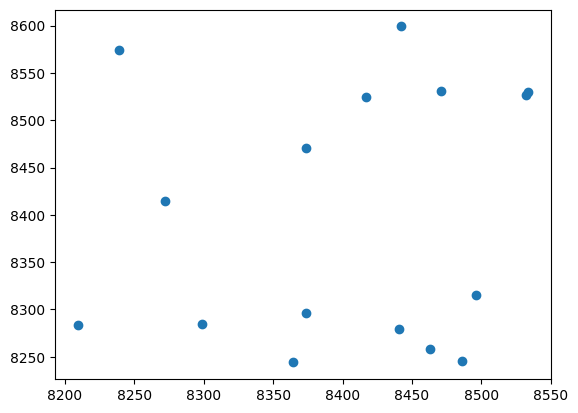

In [7]:
#plt.scatter(x, y)